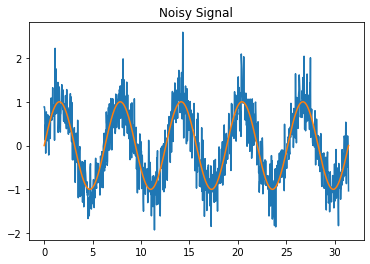

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import signal
from scipy.optimize import curve_fit
import math
np.random.seed(123456789)

tspan =  np.linspace(0, 10*np.pi, 1000) 
teval = 0
Vin = lambda t: np.sin(t)
mynoise = 0.4*np.random.randn(*Vin(tspan).shape)
Vinarray = Vin(tspan) + mynoise

plt.plot(tspan, Vinarray)
plt.plot(tspan, Vin(tspan))
plt.title("Noisy Signal")
plt.show()

In [2]:
tau = 1
tau2 = 1
#Used to find t with the scipy integraton
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

In [3]:
#filters
def lowpass(t, y):  
    dydt = (1/tau)*(Vinarray[find_nearest(tspan, t)]-y)
    return dydt

def highpass(t, y):
    dydt = (Vinarray[find_nearest(tspan, t)]+Vinarray[find_nearest(tspan, t)-1])/(tspan[find_nearest(tspan, t)]-tspan[find_nearest(tspan, t)-1])-y/tau
    return dydt   

def bandpass(t, y):
    low = solve_ivp(lambda t, y: lowpass(t, y),[tspan[0], tspan[-1]],[0], t_eval=tspan)
    dydt = (low.y[0,find_nearest(tspan, t)]+low.y[0, find_nearest(tspan, t)-1])/(tspan[find_nearest(tspan, t)]-tspan[find_nearest(tspan, t)-1])-y/tau2
    return dydt  

def butterworth(t, order, freq):
    order = int(order)
    freqarray = np.empty(1)
    freqarray[0] = freq
    b, a = signal.butter(order, freqarray)
    y = signal.filtfilt(b, a, Vinarray)
    return y[np.where(tspan==t)]

#necessary because curve_fit only finds local minima
def butterglobalmin(orders):
    popt, pcov = curve_fit(butterworth, tspan, Vin(tspan), p0=[1, 0.5], bounds=(0, [np.inf, 0.99]))
    minerr = np.linalg.norm(Vin(tspan)-butterworth(tspan, *popt))
    minorder = 1
    for order in range (2, orders):
        popt, pcov = curve_fit(butterworth, tspan, Vin(tspan), p0=[order, 0.5], bounds=(0, [np.inf, 0.99]))
        err = np.linalg.norm(Vin(tspan)-butterworth(tspan, *popt))
        if (err < minerr):
            minorder = order
            minerr = err
    minpopt, minpcov = curve_fit(butterworth, tspan, Vin(tspan), p0=[minorder, 0.5], bounds=(0, [np.inf, 0.99]))
    y = butterworth(tspan, *minpopt)
    return y, minpopt
    
b, a = scipy.signal.cheby1(1, 20, 0.2)
y = scipy.signal.filtfilt(b, a, Vinarray)
plt.plot(tspan,  y)

b, a = scipy.signal.cheby2(1, 20, 0.2)
y = scipy.signal.filtfilt(b, a, Vinarray)
plt.plot(tspan, y)


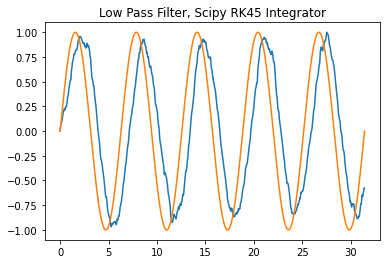

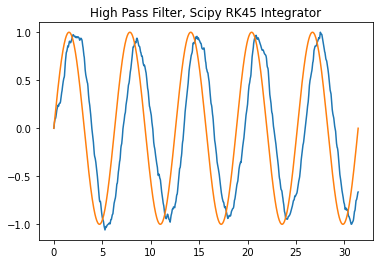

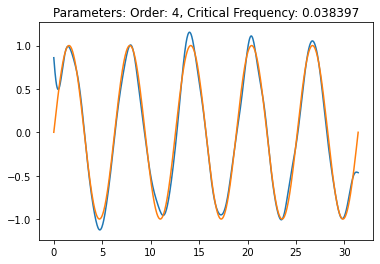

In [4]:
sol_low = solve_ivp(lambda t, y: lowpass(t, y),[tspan[0], tspan[-1]],[0], t_eval=tspan)
plt.plot(sol_low.t, sol_low.y[0,:]/np.amax(sol_low.y))
plt.plot(tspan, Vin(tspan))
plt.title("Low Pass Filter, Scipy RK45 Integrator")
plt.show()

sol_high = solve_ivp(lambda t, y: highpass(t, y),[tspan[0], tspan[-1]],[0], t_eval=tspan)
plt.plot(sol_high.t, sol_high.y[0,:]/np.amax(sol_high.y))
plt.plot(tspan, Vin(tspan))
plt.title("High Pass Filter, Scipy RK45 Integrator")
plt.show()

#sol_band = solve_ivp(lambda t, y: bandpass(t, y),[tspan[0], tspan[-1]],[0], t_eval=tspan)
#plt.plot(sol_band.t, sol_band.y[0,:])
#plt.plot(tspan, Vin(tspan))
#plt.title("Band Pass Filter, Scipy RK45 Integrator")
#plt.show()

plt.plot(tspan, butterglobalmin(10)[0])
plt.plot(tspan, Vin(tspan))
plt.title("Parameters: Order: %d, Critical Frequency: %f" %(int(butterglobalmin(10)[1][0]), butterglobalmin(10)[1][1]))
plt.show()